# Jakub Bandurski, Michał Bryzik, Kacper Gruca
## Text Mining and Social Media Mining Project

In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import random
from sklearn.metrics import confusion_matrix
from gensim.models import word2vec
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

### Specifying classification workflow

In order to classify whether the given subreddit text should belong to +18 category or not, we will follow a specific process:
- Transform text data into TF-IDF representation and word embedding
- Specify train/test subset
- Specify utilized models, and their parameters grids
- Perform GridSearch in order to find reasonable parameters
- Train the chosen models on df_train 
- Predict the categories on df_test and present evaluation metric [confusion matrix & F1 score]

Firstly let's read the already precleaned data [in 1_text_cleaning.ipynb]

In [4]:
df = pd.read_pickle("../data/nsfw_cleaned.pkl")

In [5]:
df.head()

,body,numberOfComments,over18,upVotes
0,didnt happen like year ago feel like fever dre...,95,False,392
1,f alway say 's ugli old stuff like nobodi like...,244,True,867
2,hi im f dental assist clean accident get prick...,265,False,920
3,context wife f parent beauti toddler ym f rent...,138,True,1372
4,yesterday 's fuckup spill go crazi f frequent ...,31,False,45


In [6]:
df.isnull().sum()

body                0
numberOfComments    0
over18              0
upVotes             0
dtype: int64

In [7]:
df["over18"].value_counts()/len(df)

False    0.821871
True     0.178129
Name: over18, dtype: float64

Split the dataset into train and test subsets. We will use StratifiedShuffleSplit as our dependant variable is highly imbalanced 

In [11]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.25)

for train_index, test_index in split.split(df,
                                           df["over18"]): 
    df_train = df.reindex(train_index)
    df_test = df.reindex(test_index)

In [12]:
df_train = df_train.drop(columns=["numberOfComments", "upVotes"])

In [14]:
len(df_train), len(df_test)

(665, 222)

In [15]:
df_train["over18"].value_counts()/len(df_train)

False    0.822556
True     0.177444
Name: over18, dtype: float64

In [16]:
df_test["over18"].value_counts()/len(df_test)

False    0.81982
True     0.18018
Name: over18, dtype: float64

As we can see StratifiedShuffleSplit divided the dataset so subsamples resembles proportions of original dataframe.

Now let's Specify the models grid, and parameters grid that will be utilized by grid search. 
For Logistic Regression and Random Forest we have used class_weight = 'balanced' in order to increase the Specificity. 

In [18]:
models_params = [
    {'name': 'SVC', 'classifier': SVC(), 'param_grid': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}},
    {'name': 'Logistic Regression', 'classifier': LogisticRegression(class_weight='balanced'), 'param_grid': {'classifier__C': [0.1, 0.5, 1], 'classifier__solver': ['saga']}},
    {'name': 'Logistic Regression_L2', 'classifier': LogisticRegression(class_weight='balanced'), 'param_grid': {'classifier__C': [0.1, 0.5, 1], 'classifier__penalty':['l2'], 'classifier__solver': ['saga']}},
    {'name': 'Random Forest', 'classifier': RandomForestClassifier(class_weight='balanced'), 'param_grid': {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [5, 10, 20]}}
]

In [9]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### TF-IDF vectorizer approach

Let's run the pipeline utilizing TFidfVectorizer() and compare the results among 4 models' approach.

Fitting 5 folds for each of 36 candidates, totalling 180 fits
SVC - Best F1 Score on Validation: 0.2981379920389208
SVC - Best Parameters: {'classifier__C': 10, 'classifier__kernel': 'linear', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}



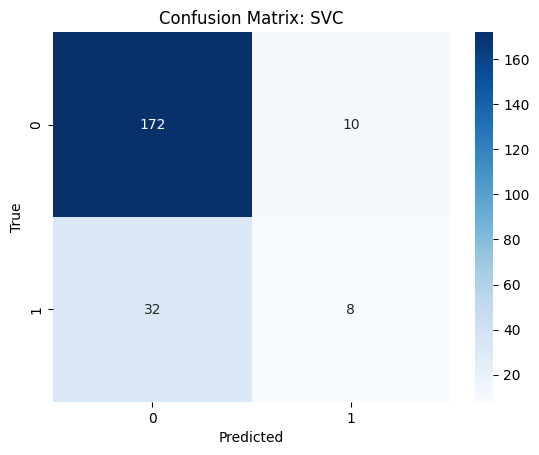

SVC - F1 Score on Test: 0.2758620689655173

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Logistic Regression - Best F1 Score on Validation: 0.40885766341807184
Logistic Regression - Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'saga', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}



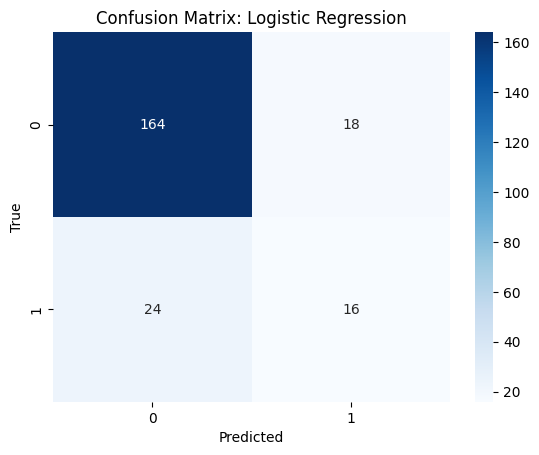

Logistic Regression - F1 Score on Test: 0.4324324324324324

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Logistic Regression_L2 - Best F1 Score on Validation: 0.4124430641821946
Logistic Regression_L2 - Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 1)}



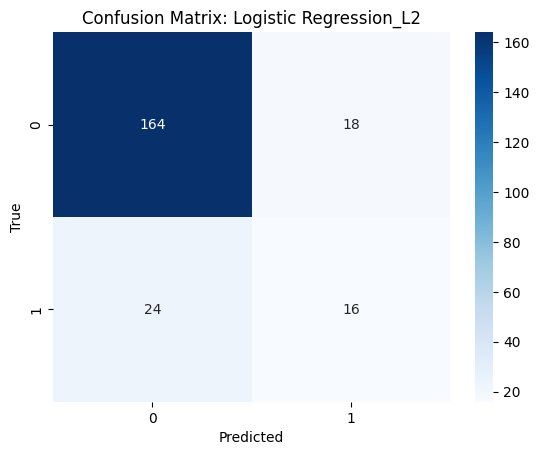

Logistic Regression_L2 - F1 Score on Test: 0.4324324324324324

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest - Best F1 Score on Validation: 0.16536819502336744
Random Forest - Best Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 50, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 1)}



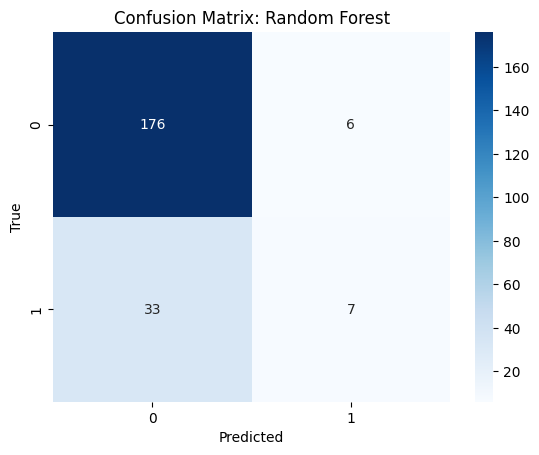

Random Forest - F1 Score on Test: 0.2641509433962264



In [20]:
for model_params in models_params:
    random.seed(20)

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', model_params['classifier'])
    ])

    param_grid = {
        'tfidf__max_features': [1000, 5000, None],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        **model_params['param_grid']
    }

    # Grid search with F1 score as the scoring metric
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(df_train['body'], df_train["over18"])

    best_model = grid_search.best_estimator_

    predictions = best_model.predict(df_test['body'])
    conf_matrix = confusion_matrix(df_test["over18"], predictions)
    
    print(f"{model_params['name']} - Best F1 Score on Validation: {grid_search.best_score_}")
    print(f"{model_params['name']} - Best Parameters: {grid_search.best_params_}\n")
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix: {model_params['name']}" )
    plt.show()

    f1_test = f1_score(df_test["over18"], predictions)
    print(f"{model_params['name']} - F1 Score on Test: {f1_test}\n")

### Word embedding approach

In order to perform clustering on word embedding, we need to:

- Tokenize sentences from documents
- Train Word2Vec model
- Transform the tokenized sentences
- Run the model pipelines onto the train/test dataset represented by numerical vectors

In [21]:
# Tokenize sentences
tokenized_train_sentences = [sentence.split() for sentence in df_train['body']]
tokenized_test_sentences = [sentence.split() for sentence in df_test['body']]

# Train Word2Vec model
word2vec_model = word2vec.Word2Vec(sentences=tokenized_train_sentences, vector_size=100, window=5, min_count=1, workers=10)

# Transform tokenized sentences
X_train_embedded = np.array([np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv] or [np.zeros(word2vec_model.vector_size)], axis=0) for sentence in tokenized_train_sentences])
X_test_embedded = np.array([np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv] or [np.zeros(word2vec_model.vector_size)], axis=0) for sentence in tokenized_test_sentences])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
SVC - Best F1 Score on Validation: 0.0
SVC - Best Parameters: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}



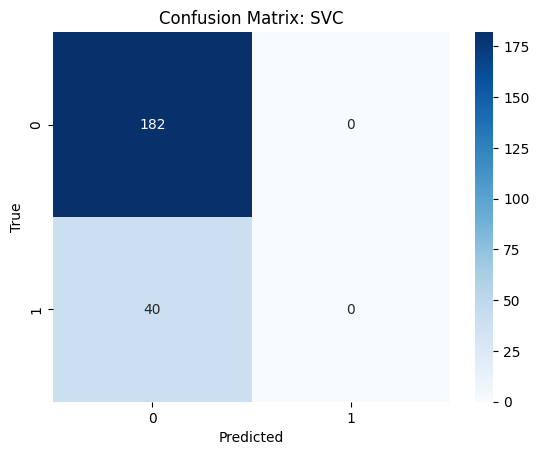

SVC - F1 Score on Test: 0.0

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Logistic Regression - Best F1 Score on Validation: 0.2412385514067253
Logistic Regression - Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'saga'}



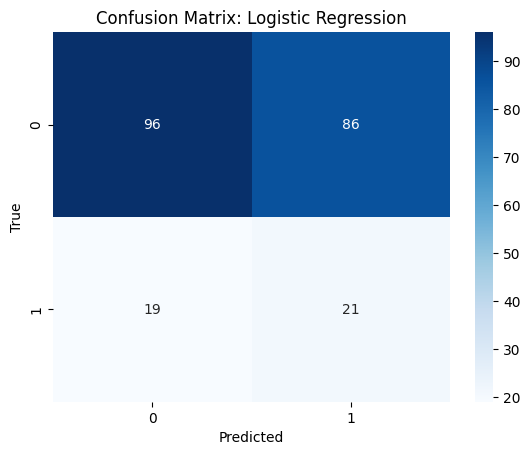

Logistic Regression - F1 Score on Test: 0.2857142857142857

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Logistic Regression_L2 - Best F1 Score on Validation: 0.2412385514067253
Logistic Regression_L2 - Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}



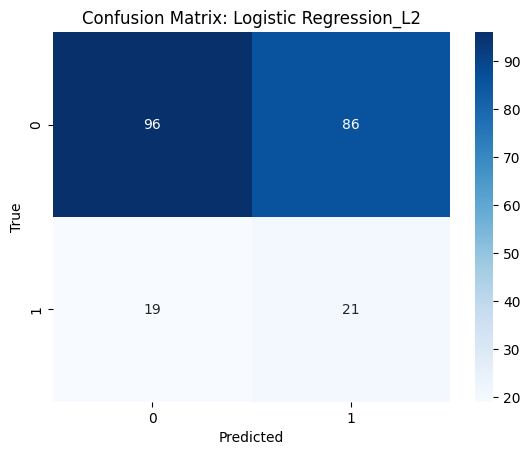

Logistic Regression_L2 - F1 Score on Test: 0.2857142857142857

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Random Forest - Best F1 Score on Validation: 0.016666666666666666
Random Forest - Best Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}



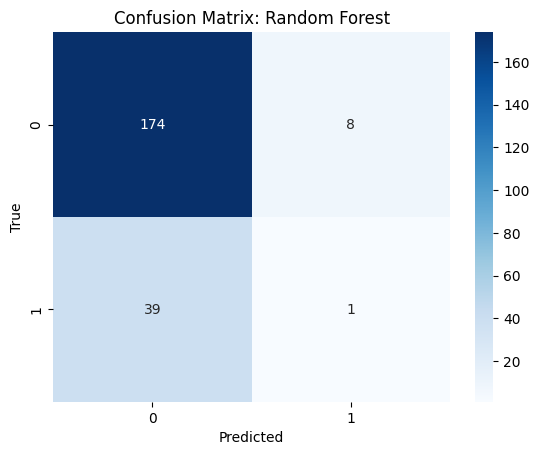

Random Forest - F1 Score on Test: 0.04081632653061225



In [23]:

for model_params in models_params:
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize the features
        ('pca', PCA(n_components=100)),  # Principal Component Analysis
        ('classifier', model_params['classifier'])
    ])

    # Combine parameter grid from models_params with embedding specific parameters
    param_grid = {
        **model_params['param_grid']
    }

    # Grid search with F1 score as the scoring metric
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(X_train_embedded, df_train["over18"])

    best_model = grid_search.best_estimator_

    predictions = best_model.predict(X_test_embedded)
    conf_matrix = confusion_matrix(df_test["over18"], predictions)
    
    print(f"{model_params['name']} - Best F1 Score on Validation: {grid_search.best_score_}")
    print(f"{model_params['name']} - Best Parameters: {grid_search.best_params_}\n")
    
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix: {model_params['name']}" )
    plt.show()

    f1_test = f1_score(df_test["over18"], predictions)
    print(f"{model_params['name']} - F1 Score on Test: {f1_test}\n")

As can be seen, much higher F1 Score was observed on clustering using TF-IDF approach. 
However word embedding has been here much simpler computationally which resulted in much faster time of execution. Nevertheless basing on the final results we can see that predicting nsfw texts isn't a simple task to do, and in order to receive a satisfactory results from word embeddings classification we would need to spend more time with hyperparameters tuning and data transformation.

Overall seemingly best predctions has been received by utilizing logistic regression, both with l2 penalization and without, resulting in rightfully predicting 16/40 nsfw cases, and overall F1-score of 0.43